## EXERCISE 3

Study the data in the file x_XGB_24.dat (N=2000 samples) with labels y_XGB_24.dat. The dataset should be split into N' training samples and N'' validation samples, with N' + N'' = N

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lucrezia | Rossi | 2122164 |
| Lorenzo | Calandra Buonaura | 2107761 |
| Andrea | Turci | 2106724 |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

XGBoost version: 2.0.3


In [2]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

N=4000, N_train=3000, L=4


[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 1
[ 24.771  46.131 -49.161 -39.356] 1
[-20.13   15.641  30.981  37.218] 1
[46.465 22.369 14.248 21.745] 1


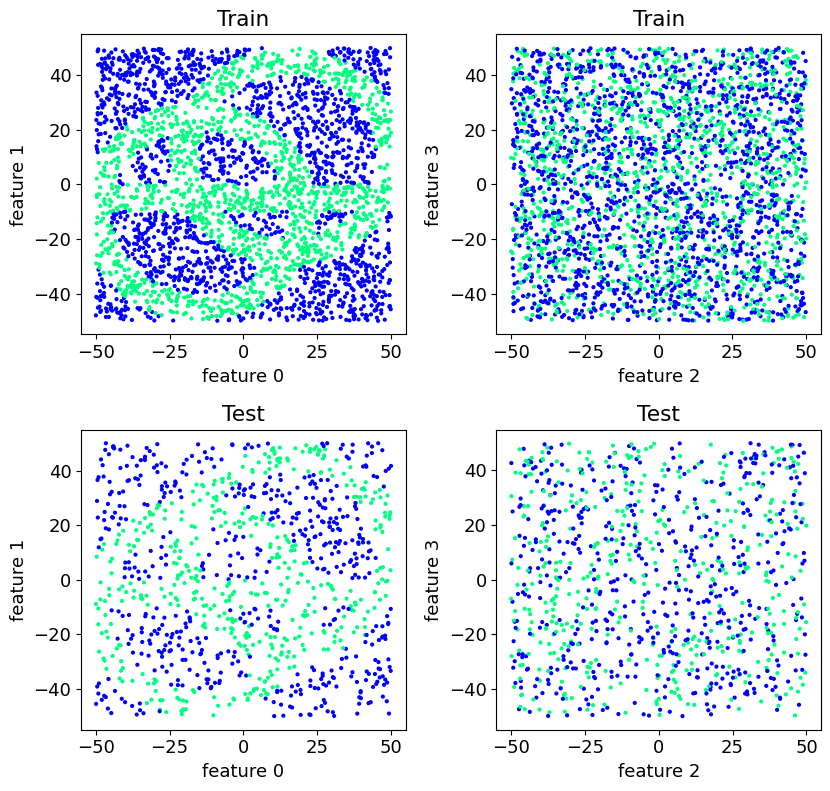

In [3]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

### 1\. Model complexity, parameters’ and regularization
Try different parameters (λ, γ, n_estimators, ...). Which is the simplest yet effective XGBoost model that keeps a good validation accuracy? Is regularization useful for this analysis?

In [62]:
def classify(clf=GradientBoostingClassifier(),show=False):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_test, y_test)),clf.score(x_test, y_test)))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    fig,AX = plt.subplots(1,2,figsize=(8.2,4))
    scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
    scat(AX[1],x_train[:],y_train,title="training set")
    fig.tight_layout()
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show()

errors: 5.20%   Accuracy=0.948


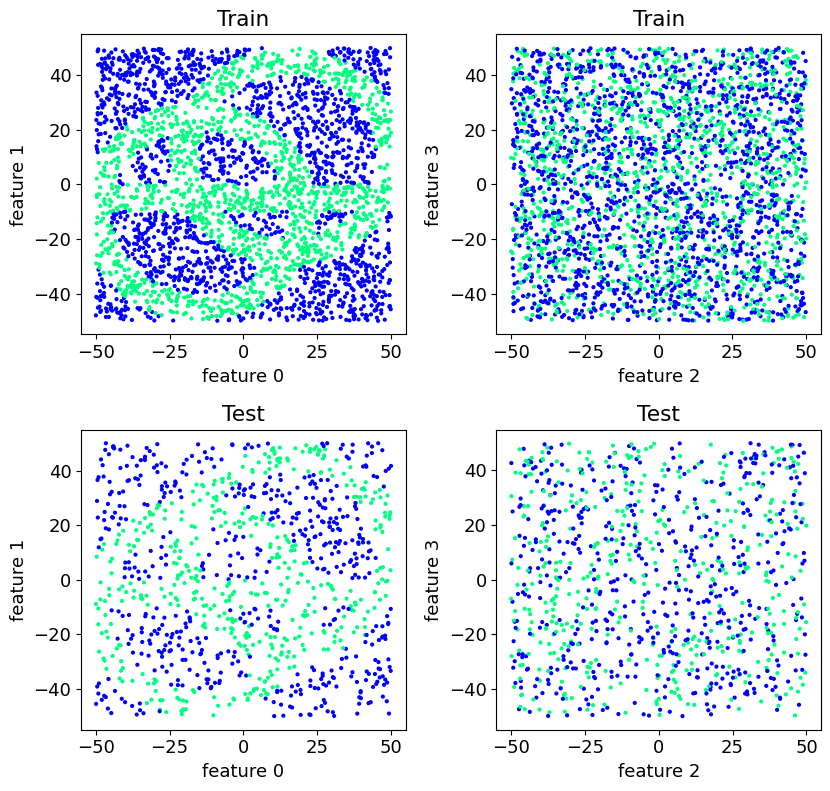

num_trees= 100


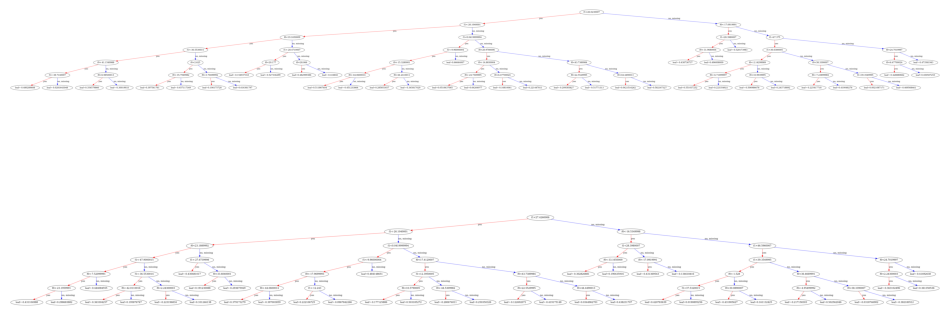

In [63]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic') 
       # importance_type="gain" #weight, cover, ...
       # learning_rate=0.4,
       # reg_lambda=0.001, 
       # n_estimators=30)

classify(model, show=True)

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

def find_best_model(x_train, y_train, x_val, y_val):
    parameters = {
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'n_estimators': [10, 50, 100, 150, 200],
        'max_depth': [3, 4, 5, 6, 7],
        'reg_lambda': [0.001, 0.01, 0.1, 0],
        'reg_alpha': [0.001, 0.01, 0.1, 0],
        'gamma': [0, 0.1, 0.2, 0.3]
    }

    model = XGBClassifier(seed=1, objective='binary:logistic')
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=3, scoring='accuracy')
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Accuracy on Training Set:", best_score)

    # Train the model on the combined training and validation set using best parameters
    best_model = XGBClassifier(**best_params, seed=1, objective='binary:logistic')
    best_model.fit(x_train, y_train)

    # Evaluate the best model on the validation set
    y_pred_val = best_model.predict(x_val)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    print("Accuracy on Validation Set:", val_accuracy)

    return best_model, best_params

best_model, best_params = find_best_model(x_train, y_train, x_test, y_test)

Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 0}
Best Accuracy on Training Set: 0.9273333333333333
Accuracy on Validation Set: 0.953


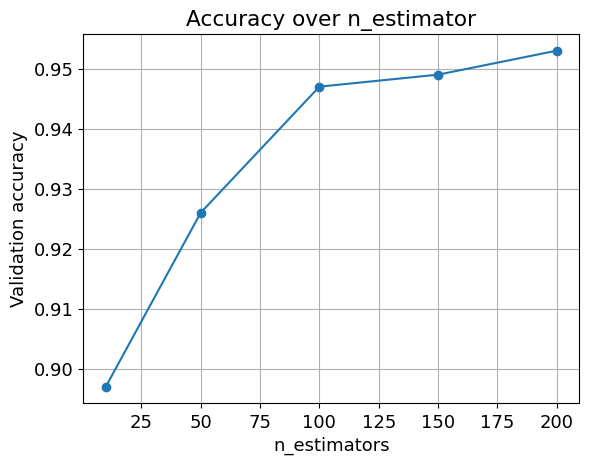

In [36]:
n_estimators = [10, 50, 100, 150, 200]
accuracies = []

for num in n_estimators:
    model = XGBClassifier(learning_rate = best_params['learning_rate'], n_estimators = num, max_depth = best_params['max_depth'], reg_lambda = best_params['reg_lambda'], reg_alpha = best_params['reg_alpha'], gamma = best_params['gamma'], seed=1, objective='binary:logistic')
    model.fit(x_train, y_train)
    y_pred_test = model.predict(x_test)
    val_accuracy = accuracy_score(y_test, y_pred_test)
    accuracies.append(val_accuracy)

plt.plot(n_estimators, accuracies, marker='o')  # Replace your_metric_values with the corresponding values you want to plot
plt.xlabel('n_estimators')
plt.ylabel('Validation accuracy')
plt.title('Accuracy over n_estimator')
plt.grid(True)
#plt.xscale('log')

plt.show()

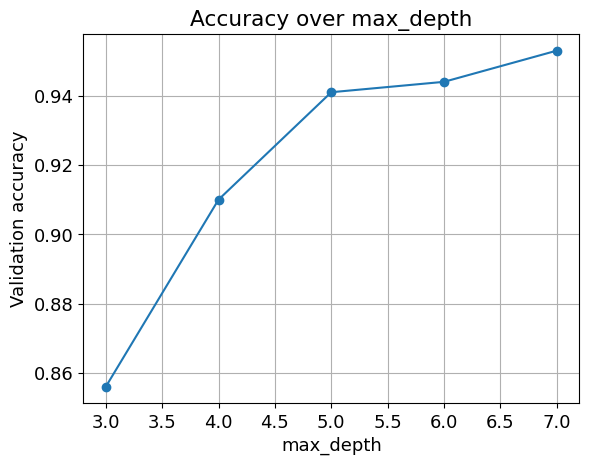

In [38]:
max_depth = [3, 4, 5, 6, 7]
accuracies = []

for depth in max_depth:
    model = XGBClassifier(learning_rate = best_params['learning_rate'], n_estimators = best_params['n_estimators'], max_depth = depth, reg_lambda = best_params['reg_lambda'], reg_alpha = best_params['reg_alpha'], gamma = best_params['gamma'], seed=1, objective='binary:logistic')
    model.fit(x_train, y_train)
    y_pred_test = model.predict(x_test)
    val_accuracy = accuracy_score(y_test, y_pred_test)
    accuracies.append(val_accuracy)

plt.plot(max_depth, accuracies, marker='o')  # Replace your_metric_values with the corresponding values you want to plot
plt.xlabel('max_depth')
plt.ylabel('Validation accuracy')
plt.title('Accuracy over max_depth')
plt.grid(True)
#plt.xscale('log')

plt.show()

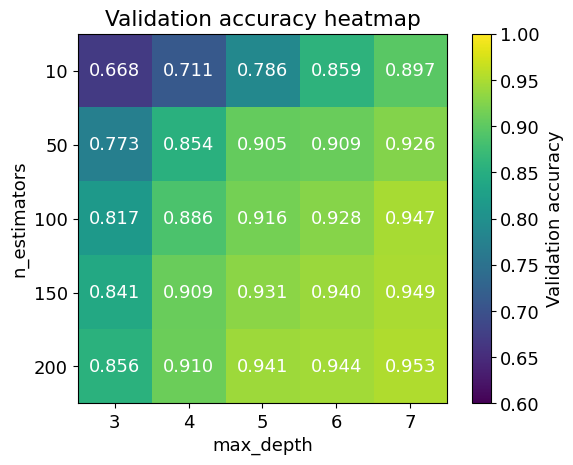

In [57]:
n_estimators = [10, 50, 100, 150, 200]
max_depth = [3, 4, 5, 6, 7]
accuracies = np.zeros((len(n_estimators), len(max_depth)))

for i, num in enumerate(n_estimators):
    for j, depth in enumerate(max_depth):
        model = XGBClassifier(learning_rate=best_params['learning_rate'], 
                              n_estimators=num, 
                              max_depth=depth, 
                              reg_lambda=best_params['reg_lambda'], 
                              reg_alpha=best_params['reg_alpha'], 
                              gamma=best_params['gamma'], 
                              seed=1, 
                              objective='binary:logistic')
        model.fit(x_train, y_train)
        y_pred_test = model.predict(x_test)
        val_accuracy = accuracy_score(y_test, y_pred_test)
        accuracies[i, j] = val_accuracy

plt.imshow(accuracies, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Validation accuracy')
plt.yticks(np.arange(len(n_estimators)), n_estimators)
plt.xticks(np.arange(len(max_depth)), max_depth)
plt.ylabel('n_estimators')
plt.xlabel('max_depth')
plt.title('Validation accuracy heatmap')
plt.clim(0.6, 1)

# Adding text annotations
for i in range(len(n_estimators)):
    for j in range(len(max_depth)):
        plt.text(j, i, f'{accuracies[i, j]:.3f}', ha='center', va='center', color='white')

plt.show()

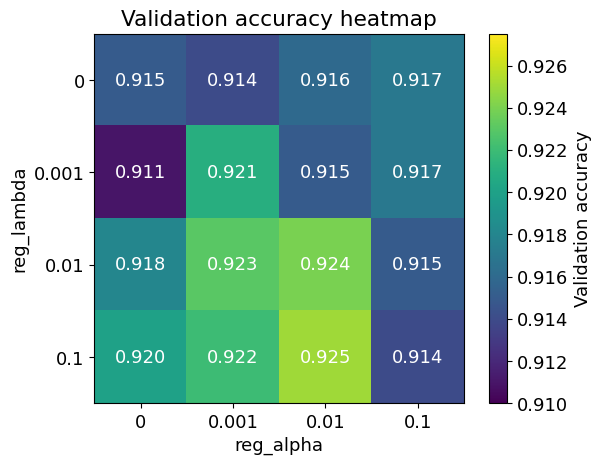

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Assuming you have initialized x_train, y_train, x_test, y_test, and best_params

reg_lambda = [0, 0.001, 0.01, 0.1]
reg_alpha = [0, 0.001, 0.01, 0.1]
accuracies = np.zeros((len(reg_lambda), len(reg_alpha)))

for i, lambd in enumerate(reg_lambda):
    for j, alpha in enumerate(reg_alpha):
        model = XGBClassifier(learning_rate=best_params['learning_rate'], 
                              n_estimators=150, 
                              max_depth=6, 
                              reg_lambda=lambd, 
                              reg_alpha=alpha, 
                              gamma=best_params['gamma'], 
                              seed=1, 
                              objective='binary:logistic')
        model.fit(x_train, y_train)
        y_pred_test = model.predict(x_test)
        val_accuracy = accuracy_score(y_test, y_pred_test)
        accuracies[i, j] = val_accuracy

plt.imshow(accuracies, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Validation accuracy')
plt.xticks(np.arange(len(reg_alpha)), reg_alpha)
plt.yticks(np.arange(len(reg_lambda)), reg_lambda)
plt.xlabel('reg_alpha')
plt.ylabel('reg_lambda')
plt.title('Validation accuracy heatmap')
plt.clim(0.91, 0.9275)


for i in range(len(reg_lambda)):
    for j in range(len(reg_alpha)):
        plt.text(j, i, f'{accuracies[i, j]:.3f}', ha='center', va='center', color='white')

plt.show()

errors: 6.20%   Accuracy=0.938


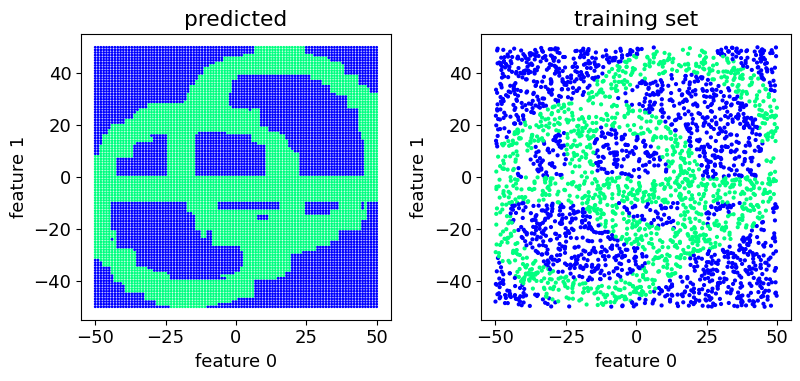

num_trees= 150


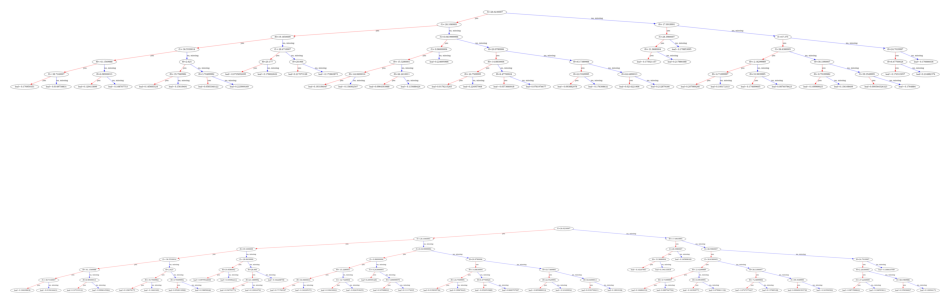

In [61]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic',
                      # importance_type="gain" #weight, cover, ...
                      learning_rate= best_params['learning_rate'], 
                      gamma = best_params['gamma'],
                      reg_lambda=0.1, 
                      reg_alpha = 0.01,
                      n_estimators=150,
                      max_depth=6)

classify(model, show=True)

### 2\. Dimensionality reduction
Consider reduced data samples with L'\<L features. For example, feature 0,1, and 3 out of the L=4 features. Check if the exclusion of the least important feature(s) from training data leads to better accuracy.

None
[0.4891835  0.37623835 0.06590363 0.06867457]


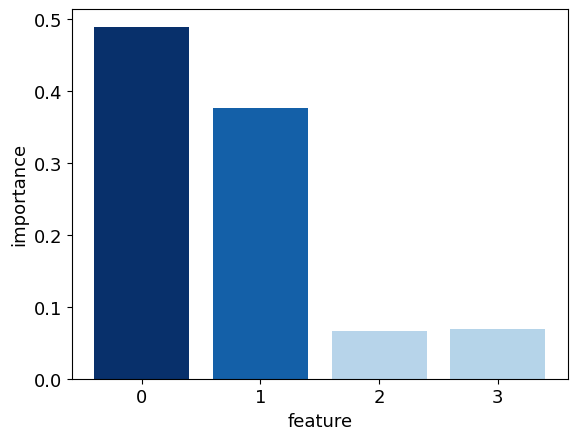

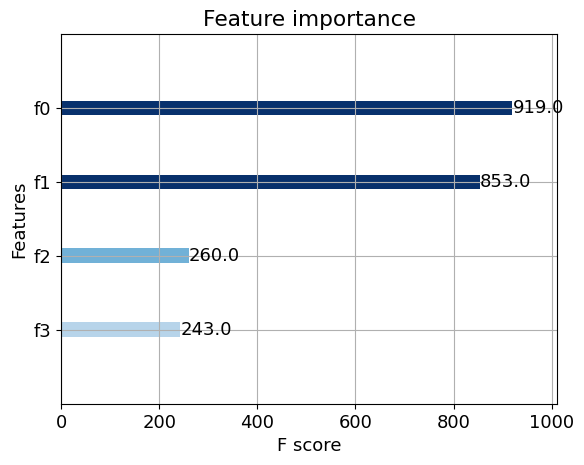

In [77]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance

print(model.importance_type)
print(model.feature_importances_)
# plot
my_cmap = plt.get_cmap("Blues")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_,
        color=my_cmap(rescale(model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(model,color=my_cmap(rescale_r(model.feature_importances_)))
plt.show()

In [71]:
from sklearn.metrics import accuracy_score

# Train the model using the original data with all features
original_model = XGBClassifier(gamma =  best_params['gamma'], learning_rate = best_params['learning_rate'], max_depth = best_params['max_depth'], n_estimators = best_params['n_estimators'], reg_lambda =  best_params['reg_lambda'], reg_alpha = best_params['reg_alpha'], seed=1, objective='binary:logistic')
original_model.fit(x_train, y_train)

# Find the index of the least important feature(s)
least_important_features_indices = [2,3]

# Exclude the least important feature(s) from the training data
x_train_reduced = np.delete(x_train, least_important_features_indices, axis=1)

# Retrain the model using the reduced data with L' features
reduced_model = XGBClassifier(gamma =  best_params['gamma'], learning_rate = best_params['learning_rate'], max_depth = best_params['max_depth'], n_estimators = best_params['n_estimators'], reg_lambda =  best_params['reg_lambda'], reg_alpha = best_params['reg_alpha'], seed=1, objective='binary:logistic')
reduced_model.fit(x_train_reduced, y_train)

# Evaluate both models on the test data
y_pred_original = original_model.predict(x_test)
accuracy_original = accuracy_score(y_test, y_pred_original)

y_pred_reduced = reduced_model.predict(np.delete(x_test, least_important_features_indices, axis=1))
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)

print("Accuracy with all features:", accuracy_original)
print("Accuracy with reduced features:", accuracy_reduced)

Accuracy with all features: 0.953
Accuracy with reduced features: 0.964


In [79]:
# Train the model using the original data with all features
original_model = XGBClassifier(gamma =  best_params['gamma'], learning_rate = best_params['learning_rate'], max_depth = 6, n_estimators = 150, reg_lambda =  0.1, reg_alpha = 0.01, seed=1, objective='binary:logistic')
original_model.fit(x_train, y_train)

least_important_features_indices = [2,3]
x_train_reduced = np.delete(x_train, least_important_features_indices, axis=1)

reduced_model = XGBClassifier(gamma =  best_params['gamma'], learning_rate = best_params['learning_rate'], max_depth = 6, n_estimators = 150, reg_lambda =  0.1, reg_alpha = 0.01, seed=1, objective='binary:logistic')
reduced_model.fit(x_train_reduced, y_train)

y_pred_original = original_model.predict(x_test)
accuracy_original = accuracy_score(y_test, y_pred_original)

y_pred_reduced = reduced_model.predict(np.delete(x_test, least_important_features_indices, axis=1))
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)

print("Accuracy with all features:", accuracy_original)
print("Accuracy with reduced features:", accuracy_reduced)

Accuracy with all features: 0.938
Accuracy with reduced features: 0.961


In [82]:
x = [[0], [1], [2], [3,2], [5, 4]]
y = [0, 5, 9, 8, 4]


# Get indices that would sort y
sorted_indices = sorted(range(len(y)), key=lambda k: y[k])

# Rearrange x based on sorted indices
x_sorted = [x[i] for i in sorted_indices]

print(x_sorted)

[[0], [5, 4], [1], [3, 2], [2]]


### 3\.  XGBoost vs NN
Compare the validation accuracy of XGBoost with that of a simple feed-forward neural network (NN):
- By varying the number of data samples N’ in the training set (i.e., reducing the fraction N’/N of the data set used for training)
- With cross-validation for all cases.

Is the NN or the XGB performing significantly better at low N’?

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense

# Define fractions of the training data
fractions = [0.3, 0.5, 0.7, 0.9]

# Initialize lists to store validation accuracies
xgb_accuracies = []
nn_accuracies = []

# Loop through different fractions
for frac in fractions:
    x_train_frac, _, y_train_frac, _ = train_test_split(x, y, train_size=frac, random_state=42)

    # Train XGBoost model
    xgb_model = XGBClassifier()
    xgb_scores = cross_val_score(xgb_model, x_train_frac, y_train_frac, cv=5)
    xgb_accuracy = xgb_scores.mean()
    xgb_accuracies.append(xgb_accuracy)

    # Train Feed-forward Neural Network
    nn_model = Sequential([
        Dense(100, activation='relu', input_shape=(x_train_frac.shape[1],)),
        Dense(1, activation='sigmoid')
    ])
    nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    nn_model.fit(x_train_frac, y_train_frac, epochs=10, batch_size=32, verbose=0)
    nn_scores = nn_model.evaluate(x_test, y_test, verbose=0)
    nn_accuracy = nn_scores[1]  # Accuracy is the second element of the scores
    nn_accuracies.append(nn_accuracy)

# Compare validation accuracies
for i, frac in enumerate(fractions):
    print(f"Fraction of Training Data: {frac}")
    print(f"XGBoost Accuracy: {xgb_accuracies[i]}")
    print(f"Neural Network Accuracy: {nn_accuracies[i]}")
    print()

# Plotting the results for visualization if needed
plt.plot(fractions, xgb_accuracies, label='XGBoost')
plt.plot(fractions, nn_accuracies, label='Neural Network')
plt.xlabel('Fraction of Training Data')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of XGBoost and Neural Network')
plt.legend()
plt.show()

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=1.